In [14]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load a non-stationary dataset
df1 = pd.read_csv('bitcoin.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

In [15]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
auto_arima(df1['q'],error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -494.963
Date:                Thu, 28 Jul 2022   AIC                            995.925
Time:                        13:38:34   BIC                           1001.476
Sample:                             0   HQIC                           998.014
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    962.8499    634.076      1.519      0.129    -279.916    2205.616
ma.L1         -0.6068      0.111     -5.478      0.000      -0.824      -0.390
sigma2      8.806e+07      0.018   4.98e+09      0.000    8.81e+07    8.81e+07
===================================================================================
Ljung-Box (Q):                       28.34   Jarque-Bera (JB):               279.28
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              29.50   Skew:                             2.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+24. Standard errors may be unstable.
"""

In [17]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [18]:
arma_order_select_ic(df1['q'])

{'bic':              0            1            2
 0  1082.263694  1059.623010  1046.015607
 1  1030.842755  1030.310771  1034.385076
 2  1033.045364  1033.337132          NaN
 3  1034.761311  1035.706490  1030.193584
 4  1031.049045  1034.563140  1033.998533,
 'bic_min_order': (3, 2)}

In [19]:
arma_order_select_ic(df1['q'])

{'bic':              0            1            2
 0  1082.263694  1059.623010  1046.015607
 1  1030.842755  1030.310771  1034.385076
 2  1033.045364  1033.337132          NaN
 3  1034.761311  1035.706490  1030.193584
 4  1031.049045  1034.563140  1033.998533,
 'bic_min_order': (3, 2)}

In [20]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [22]:
adf_test(df1['q'])

Augmented Dickey-Fuller Test: 
ADF test statistic       0.352315
p-value                  0.979621
# lags used              3.000000
# observations          44.000000
critical value (1%)     -3.588573
critical value (5%)     -2.929886
critical value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [23]:
len(df1)

48

In [29]:
train = df1.iloc[:36]
test = df1.iloc[36:]

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                        

In [56]:
model = SARIMAX(train['q'],order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      q   No. Observations:                   36
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -344.414
Date:                Thu, 28 Jul 2022   AIC                            692.828
Time:                        15:01:05   BIC                            695.938
Sample:                    01-01-2018   HQIC                           693.902
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9999      0.098    -10.247      0.000      -1.191      -0.809
sigma2      1.924e+07   5.06e-09    3.8e+15      0.000    1.92e+07    1.92e+07
===================================================================================
Ljung-Box (Q):                       18.71   Jarque-Bera (JB):               207.49
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               8.02   Skew:                            -2.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [58]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(0,1,1) Predictions')

[Text(0, 0.5, 'Chained 2012 Dollars'), Text(0.5, 0, '')]

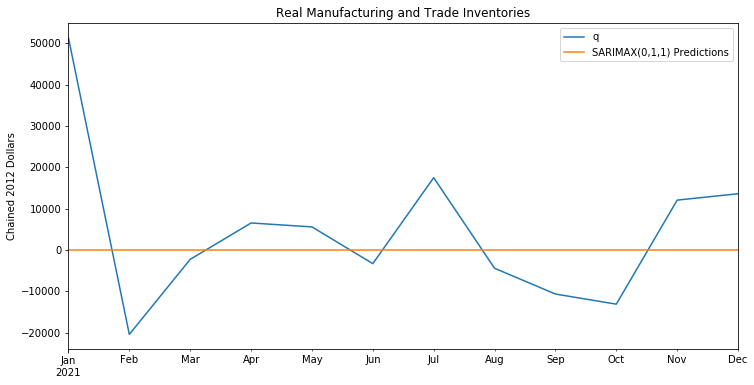

In [59]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['q'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

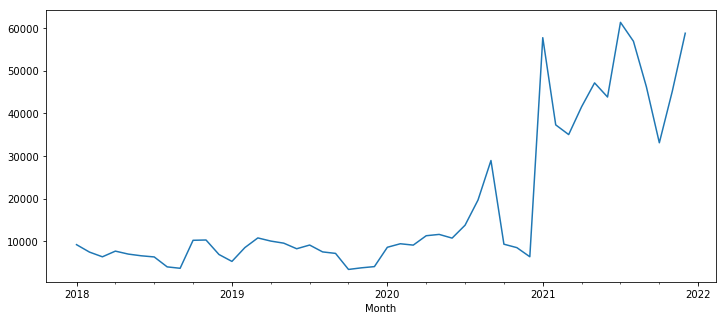

In [21]:
df1['q'].plot(figsize=(12,5));??????????????????????????????????????????

In [36]:
from statsmodels.tsa.statespace.tools import diff
df1['q'] = diff(df1['q'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df1['q'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic     -7.202474e+00
p-value                 2.345959e-10
# lags used             2.000000e+00
# observations          4.400000e+01
critical value (1%)    -3.588573e+00
critical value (5%)    -2.929886e+00
critical value (10%)   -2.603185e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


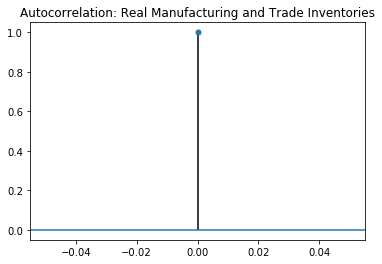

In [44]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 10
plot_pacf(df1['q'],title=title,lags=lags);

In [43]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

NameError: name 'fcast' is not defined

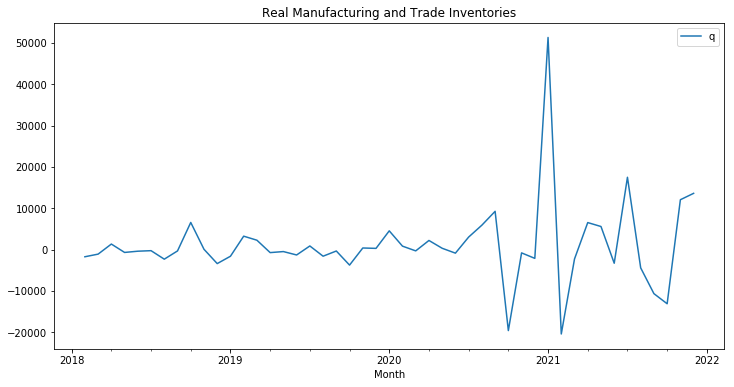

In [45]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df1['q'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);